In [1]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [2]:
# Load data into DataFrame
df = pd.read_csv('data/invitro_droplet_data.csv', comment='#')

# Check it out
df.head()

,Droplet Diameter (um),Droplet Volume (uL),Spindle Length (um),Spindle Width (um),Spindle Area (um2)
0,27.1,0.000010,28.9,10.8,155.8
1,28.2,0.000012,22.7,7.2,81.5
2,29.4,0.000013,26.2,10.5,138.3
3,31.0,0.000016,19.2,9.4,90.5
4,31.0,0.000016,28.4,12.1,172.4


In [3]:
def spindle_length(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma= p
    return gamma * d / ((1 + (gamma * d / theta)**3)**(1/3))

def log_post(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    """
    # Unpack parameters
    theta, gamma = p
    
    # Zero probability of having gamma< 0 or gamma > 1
    if gamma < 0 or gamma > 1:
        return -np.inf
    
        # Zero probability of having theta< 0 or theta > 1000
    if theta < 0 or theta > 1000:
        return -np.inf
    
    # Theoretical spindle length
    ell_theor = spindle_length(p, d)
    
    return -len(d) / 2 * np.log(np.sum((ell - ell_theor)**2))



In [4]:
n_dim = 2        # number of parameters in the model (theta and gamma)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

In [5]:
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(1,100, n_walkers)            # theta
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # gamma

In [6]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                args=(df['Droplet Diameter (um)'],df['Spindle Length (um)'],), threads=2)


In [7]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
#prob

In [8]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [9]:
print(sampler.chain.shape)
print(sampler.flatchain.shape)

(50, 5000, 2)
(250000, 2)


In [10]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
theta_MAP, gamma_MAP = sampler.flatchain[max_ind,:]



# Print the results
print("""
Most probable parameter values:
θ:  {0:.3f} µm
γ: {1:.3f}
""".format(theta_MAP, gamma_MAP))


Most probable parameter values:
θ:  38.247 µm
γ: 0.860



In [11]:
# Compute error bars by taking standard deviation
theta_err, gamma_err = sampler.flatchain.std(axis=0)

print('Error bars:\n', theta_err, gamma_err)

Error bars:
 0.39467169402 0.017720171396


In [12]:
theta_err/theta_MAP

0.010319071364546611

In [13]:
gamma_err/gamma_MAP

0.02060179843639285

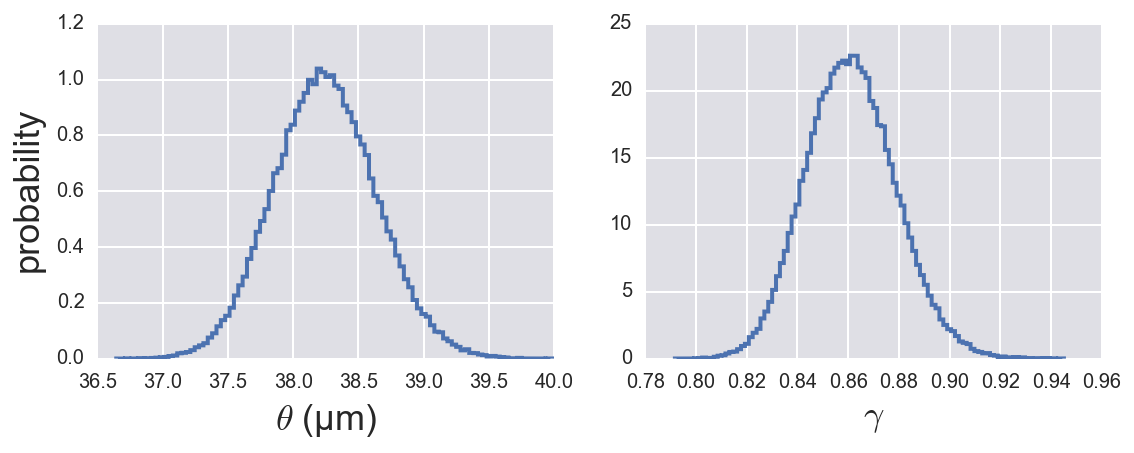

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel(r'$\theta$ (µm)')
ax[1].set_xlabel(r'$\gamma$')
ax[0].set_ylabel('probability')

## Sigma



In [45]:
def spindle_length_sigma(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma, sigma = p
    return gamma * d / ((1 + (gamma * d / theta)**3)**(1/3))

def log_post_sigma(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    p[2] = sigma
    """
    # Unpack parameters
    theta, gamma, sigma = p
    
    # Zero probability of having gamma< 0 or gamma > 1
    if gamma < 0 or gamma > 1:
        return -np.inf
    
        # Zero probability of having theta< 0 or theta > 1000
    if theta < 0 or theta > 1000:
        return -np.inf
    
            # Zero probability of having sigma< 0 or sigma > theta
    if sigma < 0:
        return -np.inf

    
    # Theoretical spindle length
    ell_theor = spindle_length_sigma(p, d)
    
    return np.log(1/(sigma**len(d)))+(-1/(2*(sigma**2)))*(np.sum((ell - ell_theor)**2))



In [61]:
n_dim = 3        # number of parameters in the model (theta and gamma)
n_walkers = 100   # number of MCMC walkers
n_burn = 1000     # "burn-in" period to let chains stabilize
n_steps = 10000   # number of MCMC steps to take after burn-in


p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(1,100, n_walkers)            # theta
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # gamma
p0[:,2] = np.random.exponential(.5, n_walkers)             # simga

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_sigma, 
                                args=(df['Droplet Diameter (um)'],df['Spindle Length (um)'],), threads=4)


In [62]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
#prob

In [63]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [64]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
theta_MAP, gamma_MAP, sigma_MAP = sampler.flatchain[max_ind,:]



# Print the results
print("""
Most probable parameter values:
θ:  {0:.3f} µm
γ: {1:.3f}
σ: {1:.3f}
""".format(theta_MAP, gamma_MAP,sigma_MAP))


Most probable parameter values:
θ:  92.382 µm
γ: 0.203
σ: 0.203



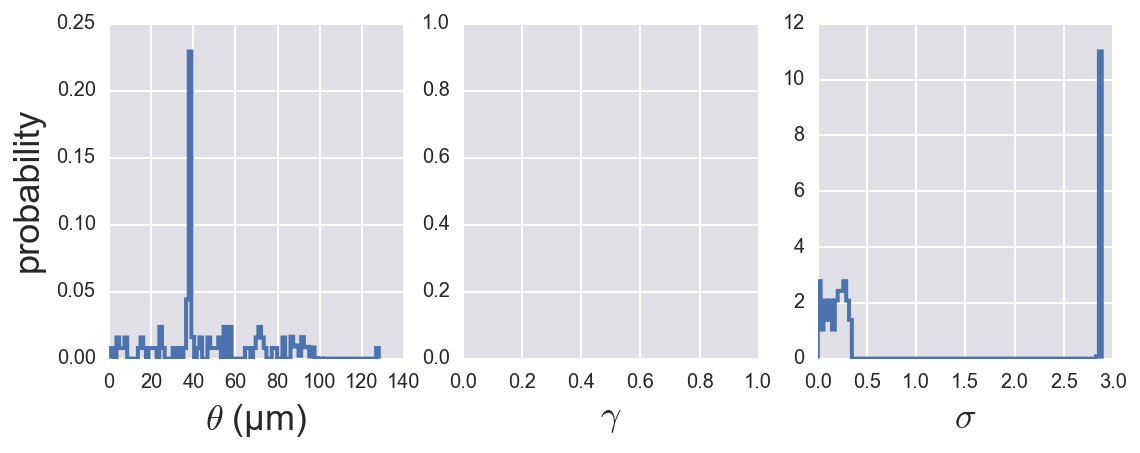

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

for i in [0, 2]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel(r'$\theta$ (µm)')
ax[1].set_xlabel(r'$\gamma$')
ax[2].set_xlabel(r'$\sigma$')
ax[0].set_ylabel('probability')

## Conlcusions from plotting 
These plots are pretty ugly, but I can't plot any more; the simulations takes too long.  

The distribution for sigma appears to be bimodal, with one mode at approximately .1-.2, but with the other centered around 3.  Becuase the prior for sigma was assumed to expoenential centered around .5, and neither peak is centered around the initial distribution, we can conclude that neither of these peaks are artifacts from undersampling.

A bimodal error distribution might suggest that there is a confounding factor in determining spindle size.  Usually, the the model predicts spindle size pretty accurately, but for some cases, the error is significantly higher. This could indicate that the mdoel is too simple, and a thrid parameter is needed to accurately predict spindle size.   
